## Assignment : 14

In [0]:
%tensorflow_version 1.x

In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from math import ceil
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from keras.utils import to_categorical
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Input, Dense, Flatten, LSTM,\
                      Dropout, concatenate, Conv1D,BatchNormalization
from tensorflow.keras import regularizers,initializers,optimizers,Model
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.feature_extraction.text import TfidfVectorizer

Using TensorFlow backend.


<pre>
1. Preprocess all the Data we have in DonorsChoose <a href='https://drive.google.com/drive/folders/1MIwK7BQMev8f5CbDDVNLPaFGB32pFN60'>Dataset</a> use train.csv
2. Combine 4 essay's into one column named - 'preprocessed_essays'. 
3. After step 2 you have to train 3 types of models as discussed below. 
4. For all the model use <a href='https://scikit-learn.org/stable/modules/model_evaluation.html#roc-metrics'>'auc'</a> as a metric. check <a href='https://datascience.stackexchange.com/a/20192'>this</a> for using auc as a metric 
5. You are free to choose any number of layers/hiddden units but you have to use same type of architectures shown below. 
6. You can use any one of the optimizers and choice of Learning rate and momentum, resources: <a href='http://cs231n.github.io/neural-networks-3/'>cs231n class notes</a>, <a href='https://www.youtube.com/watch?v=hd_KFJ5ktUc'>cs231n class video</a>. 
7. For all the model's use <a href='https://www.youtube.com/watch?v=2U6Jl7oqRkM'>TensorBoard</a> and plot the Metric value and Loss with epoch. While submitting, take a screenshot of plots and include those images in .ipynb notebook and PDF. 
8. Use Categorical Cross Entropy as Loss to minimize.
</pre>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
dir_path="/content/drive/My Drive/Colab Notebooks/AppliedAI/LSTM_Donors_Choose/"

In [4]:
table = PrettyTable(field_names=["Model","Weighted Test AUC","Micro Test AUC"])
print(table)

+-------+-------------------+----------------+
| Model | Weighted Test AUC | Micro Test AUC |
+-------+-------------------+----------------+
+-------+-------------------+----------------+


In [0]:
with open(dir_path+'glove_vectors', 'rb') as f:
    glove = pickle.load(f)

In [0]:
# _df_Resource = pd.read_csv(dir_path+'resources.csv')
# _df_Resource.head()

In [0]:
# _df_train = pd.read_csv(dir_path+'train_data.csv')
# _df_train.head()

In [7]:
preprocessed_df=pd.read_csv(dir_path+'preprocessed_data.csv')
preprocessed_df.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [8]:
print(preprocessed_df.shape)
print(preprocessed_df.columns)

(109248, 9)
Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price'],
      dtype='object')


In [0]:
project_approved = preprocessed_df.project_is_approved
preprocessed_df.drop(columns='project_is_approved', inplace=True)

In [0]:
# this is random splitting into train and test set
dfX_train, dfX_test, y_train, y_test = train_test_split(preprocessed_df,
                              project_approved,test_size=0.30, random_state = 0,
                              stratify = project_approved)
dfX_cv, dfX_test, y_cv, y_test = train_test_split(dfX_test,
                              y_test,test_size=0.50, random_state = 0,
                              stratify = y_test)

In [0]:
# For column school state

tokenizer_schoolState = Tokenizer(oov_token='<oov>')
tokenizer_schoolState.fit_on_texts(dfX_train.school_state.to_list())

In [0]:
max_schoolState_length = dfX_train.school_state.apply(lambda x : len(x.split(' '))).max()
tokenised_schoolState_train = tokenizer_schoolState.texts_to_sequences(dfX_train.school_state)
tokenised_schoolState_test = tokenizer_schoolState.texts_to_sequences(dfX_test.school_state)
tokenised_schoolState_cv = tokenizer_schoolState.texts_to_sequences(dfX_cv.school_state)

In [0]:
X_train_schoolState = pad_sequences(tokenised_schoolState_train, 
                                    maxlen=max_schoolState_length)
X_test_schoolState = pad_sequences(tokenised_schoolState_test,
                                    maxlen=max_schoolState_length)
X_cv_schoolState = pad_sequences(tokenised_schoolState_cv,
                                    maxlen=max_schoolState_length)

In [0]:
# For column teacher_prefix

tokenizer_teacherPrefix = Tokenizer(oov_token='<oov>')
tokenizer_teacherPrefix.fit_on_texts(dfX_train.teacher_prefix.to_list())

In [0]:
max_teacherPrefix_length = dfX_train.teacher_prefix.apply(lambda x : len(x.split(' '))).max()
tokenised_teacherPrefix_train = tokenizer_teacherPrefix.texts_to_sequences(dfX_train.teacher_prefix)
tokenised_teacherPrefix_test = tokenizer_teacherPrefix.texts_to_sequences(dfX_test.teacher_prefix)
tokenised_teacherPrefix_cv = tokenizer_teacherPrefix.texts_to_sequences(dfX_cv.teacher_prefix)

In [0]:
X_train_teacherPrefix = pad_sequences(tokenised_teacherPrefix_train, 
                                    maxlen=max_teacherPrefix_length)
X_test_teacherPrefix = pad_sequences(tokenised_teacherPrefix_test,
                                    maxlen=max_teacherPrefix_length)
X_cv_teacherPrefix = pad_sequences(tokenised_teacherPrefix_cv,
                                    maxlen=max_teacherPrefix_length)

In [0]:
# For column project_grade_category

tokenizer_pgCategory = Tokenizer(oov_token='<oov>',
                        filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer_pgCategory.fit_on_texts(dfX_train.project_grade_category.to_list())

In [0]:
max_pgCategory_length = dfX_train.project_grade_category.apply(lambda x : len(x.split(' '))).max()
tokenised_pgCategory_train = tokenizer_pgCategory.texts_to_sequences(dfX_train.project_grade_category)
tokenised_pgCategory_test = tokenizer_pgCategory.texts_to_sequences(dfX_test.project_grade_category)
tokenised_pgCategory_cv = tokenizer_pgCategory.texts_to_sequences(dfX_cv.project_grade_category)

In [0]:
X_train_pgCategory = pad_sequences(tokenised_pgCategory_train, 
                                    maxlen=max_pgCategory_length)
X_test_pgCategory = pad_sequences(tokenised_pgCategory_test,
                                    maxlen=max_pgCategory_length)
X_cv_pgCategory = pad_sequences(tokenised_pgCategory_cv,
                                    maxlen=max_pgCategory_length)

In [20]:
tokenizer_pgCategory.index_word

{1: '<oov>',
 2: 'grades_prek_2',
 3: 'grades_3_5',
 4: 'grades_6_8',
 5: 'grades_9_12'}

In [0]:
# For column clean_categories

tokenizer_cleanCategory = Tokenizer(oov_token='<oov>',
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer_cleanCategory.fit_on_texts(dfX_train.clean_categories.to_list())

In [0]:
max_cleanCategory_length = dfX_train.clean_categories.apply(lambda x : len(x.split(' '))).max()
tokenised_cleanCategory_train = tokenizer_cleanCategory.texts_to_sequences(dfX_train.clean_categories)
tokenised_cleanCategory_test = tokenizer_cleanCategory.texts_to_sequences(dfX_test.clean_categories)
tokenised_cleanCategory_cv = tokenizer_cleanCategory.texts_to_sequences(dfX_cv.clean_categories)

In [0]:
X_train_cleanCategory = pad_sequences(tokenised_cleanCategory_train, 
                                    maxlen=max_cleanCategory_length)
X_test_cleanCategory = pad_sequences(tokenised_cleanCategory_test,
                                    maxlen=max_cleanCategory_length)
X_cv_cleanCategory = pad_sequences(tokenised_cleanCategory_cv,
                                    maxlen=max_cleanCategory_length)

In [0]:
# For column clean_subcategories

tokenizer_cleanSubCategory = Tokenizer(oov_token='<oov>',
                          filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer_cleanSubCategory.fit_on_texts(dfX_train.clean_subcategories.to_list())

In [0]:
max_cleanSubCategory_length = dfX_train.clean_subcategories.apply(lambda x : len(x.split(' '))).max()
tokenised_cleanSubCategory_train = tokenizer_cleanSubCategory.texts_to_sequences(dfX_train.clean_subcategories)
tokenised_cleanSubCategory_test = tokenizer_cleanSubCategory.texts_to_sequences(dfX_test.clean_subcategories)
tokenised_cleanSubCategory_cv = tokenizer_cleanSubCategory.texts_to_sequences(dfX_cv.clean_subcategories)

In [0]:
X_train_cleanSubCategory = pad_sequences(tokenised_cleanSubCategory_train, 
                                    maxlen=max_cleanSubCategory_length)
X_test_cleanSubCategory = pad_sequences(tokenised_cleanSubCategory_test,
                                    maxlen=max_cleanSubCategory_length)
X_cv_cleanSubCategory = pad_sequences(tokenised_cleanSubCategory_cv,
                                    maxlen=max_cleanSubCategory_length)

In [0]:
# For column essay

tokenizer_Essay = Tokenizer(oov_token='<oov>')
tokenizer_Essay.fit_on_texts(dfX_train.essay.to_list())

In [0]:
# we found the max_essay_length using max length of list of the tokens
max_essay_length = 350
tokenised_essay_train = tokenizer_Essay.texts_to_sequences(dfX_train.essay)
tokenised_essay_test = tokenizer_Essay.texts_to_sequences(dfX_test.essay)
tokenised_essay_cv = tokenizer_Essay.texts_to_sequences(dfX_cv.essay)

In [0]:
X_train_essay = pad_sequences(tokenised_essay_train, maxlen=max_essay_length)
X_test_essay = pad_sequences(tokenised_essay_test, maxlen=max_essay_length)
X_cv_essay = pad_sequences(tokenised_essay_cv, maxlen=max_essay_length)

In [0]:
EMBEDDING_DIMS = 300     # glove vectors are 300 dims
VOCAB_SIZE = len(list(tokenizer_Essay.word_counts.keys()))
embedding_matrix = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIMS))
for word, i in tokenizer_Essay.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i-1] = embedding_vector

In [31]:
preprocessed_df.columns

Index(['school_state', 'teacher_prefix', 'project_grade_category',
       'teacher_number_of_previously_posted_projects', 'clean_categories',
       'clean_subcategories', 'essay', 'price'],
      dtype='object')

### Model-1

Build and Train deep neural network as shown below

<img src='https://i.imgur.com/w395Yk9.png'>
ref: https://i.imgur.com/w395Yk9.png

- __Input_seq_total_text_data__ --- You have to give Total text data columns. After this use the Embedding layer to get word vectors. Use given predefined glove word vectors, don't train any word vectors. After this use LSTM and get the LSTM output and Flatten that output. 
- __Input_school_state__ --- Give 'school_state' column as input to embedding layer and Train the Keras Embedding layer. 
- __Project_grade_category__  --- Give 'project_grade_category' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_categories__ --- Give 'input_clean_categories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_clean_subcategories' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_clean_subcategories__ --- Give 'input_teacher_prefix' column as input to embedding layer and Train the Keras Embedding layer.
- __Input_remaining_teacher_number_of_previously_posted_projects._resource_summary_contains_numerical_digits._price._quantity__ ---concatenate remaining columns and add a Dense layer after that. 



- For LSTM, you can choose your sequence padding methods on your own or you can train your LSTM without padding, there is no restriction on that.

Below is an example of embedding layer for a categorical columns. In below code all are dummy values, we gave only for referance. 

In [0]:
from sklearn.metrics import roc_auc_score,accuracy_score
import tensorflow as tf

# def auc( y_true, y_pred ):
#     # This is for calculating the AUC Score
#     # Added this code as sometimes the y_true comes to be of a single class
#     # causing error
#     # https://stackoverflow.com/questions/45139163/roc-auc-score-only-one-class-present-in-y-true

#     score = 0.0
#     if len(np.unique(y_true)) == 1: # bug in roc_auc_score
#         score = tf.py_func(lambda y_true, y_pred : accuracy_score(y_true, 
#                                           y_pred).astype('float32'),
#                         [y_true, y_pred],
#                         'float32',
#                         stateful=True,
#                         name='sklearnAUC' )
#     else:
#         score = tf.py_func( lambda y_true, y_pred : roc_auc_score(y_true, y_pred, 
#                         average='weighted', sample_weight=None).astype('float32'),
#                         [y_true, y_pred],
#                         'float32',
#                         stateful=True,
#                         name='sklearnAUC' )
        
#     return score

def auc_temp(y_true, y_pred):
    if len(np.unique(y_true[:,1])) == 1:
        return 0.5
    else:
        return roc_auc_score(y_true, y_pred, average='weighted')

def auc(y_true, y_pred):
    return tf.py_function(auc_temp, (y_true, y_pred), tf.double)

In [0]:
# https://stats.stackexchange.com/questions/270546/how-does-keras-embedding-layer-work
# input_layer = Input(shape=(n,))
# embedding = Embedding(no_1, no_2, input_length=n)(input_layer)
# flatten = Flatten()(embedding)

In [33]:
# school state imput
school_state_inp = Input(shape=(max_schoolState_length,), dtype='int32',
                         name='school_state_inp')
embedded_school_state = Embedding(input_dim=len(tokenizer_schoolState.word_index.items()),   # 51
                            output_dim=6,name='embedded_school_state')(school_state_inp)
school_state_out = Flatten()(embedded_school_state)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
# teacher prefix
teacher_Pref_inp = Input(shape=(max_teacherPrefix_length,),dtype='int32',
                         name='teacher_Pref_inp')
embedded_teacher_Pref = Embedding(input_dim=len(tokenizer_teacherPrefix.word_index.items()),
                        output_dim=2,name='embedded_teacher_Pref')(teacher_Pref_inp)
teacher_Pref_out = Flatten()(embedded_teacher_Pref)

In [0]:
# project grade category
pgCategory_Inp = Input(shape=(max_pgCategory_length,),dtype='int32',
                       name='pgCategory_Inp')
embedded_pgCategory = Embedding(input_dim=len(tokenizer_pgCategory.word_index.items()),
                        output_dim=2,name='embedded_pgCategory')(pgCategory_Inp)
pgCategory_Out = Flatten()(embedded_pgCategory)

In [0]:
# project clean_categories
cleanCategory_Inp = Input(shape=(max_cleanCategory_length,),dtype='int32',
                          name='cleanCategory_Inp')
embedded_cleanCategory = Embedding(input_dim=len(tokenizer_cleanCategory.word_index.items()),
                        output_dim=3,name='embedded_cleanCategory')(cleanCategory_Inp)
cleanCategory_Out = Flatten()(embedded_cleanCategory)

In [0]:
# project clean_subcategories
clean_subcategories_Inp = Input(shape=(max_cleanSubCategory_length,),dtype='int32',
                                name='clean_subcategories_Inp')
embedded_cleanSubCategory = Embedding(input_dim=len(tokenizer_cleanSubCategory.word_index.items()),
                        output_dim=5,name='embedded_cleanSubCategory')(clean_subcategories_Inp)
clean_subcategories_Out = Flatten()(embedded_cleanSubCategory)

In [0]:
# essay
essay_Inp = Input(shape=(max_essay_length,),dtype='int32',
                  name='essay_Inp')
embedded_Essay = Embedding(input_dim=len(tokenizer_Essay.word_index.items()),
                        output_dim=300,name='embedded_Essay',
                        weights=[embedding_matrix],
                        trainable=False)(essay_Inp)
essay_LSTM = LSTM(units=128, return_sequences=True)(embedded_Essay)
essay_Out = Flatten()(essay_LSTM)

In [39]:
# concatenating remaining columns teacher_number_of_previously_posted_projects 
# and price

dfX_train['remaining_cols']=dfX_train[['teacher_number_of_previously_posted_projects',
    'price']].apply(
    lambda x : [x.teacher_number_of_previously_posted_projects, x.price],
    axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
dfX_test['remaining_cols']=dfX_test[['teacher_number_of_previously_posted_projects',
    'price']].apply(
    lambda x : [x.teacher_number_of_previously_posted_projects, x.price],
    axis=1)

In [0]:
dfX_cv['remaining_cols']=dfX_cv[['teacher_number_of_previously_posted_projects',
    'price']].apply(
    lambda x : [x.teacher_number_of_previously_posted_projects, x.price],
    axis=1)

In [0]:
remaining_cols_Inp = Input(shape=(2,), dtype='float32', name='remaining_cols_Inp')
dense_remaining = Dense(16,activation='relu',
                        kernel_regularizer=regularizers.l2(0.001),
                        kernel_initializer=initializers.he_normal())
remaining_cols_Out = dense_remaining(remaining_cols_Inp)

In [0]:
# concatenating all the outputs

concatenated_Outs = concatenate([school_state_out, teacher_Pref_out,
                pgCategory_Out,cleanCategory_Out,clean_subcategories_Out,
                essay_Out,remaining_cols_Out])

In [0]:
outPut = Dense(128,activation='relu',
               kernel_initializer=initializers.he_normal(),
               kernel_regularizer=regularizers.l2(0.001))(concatenated_Outs)
outPut = Dropout(0.4)(outPut)
outPut = Dense(64,activation='relu',
               kernel_initializer=initializers.he_normal(),
               kernel_regularizer=regularizers.l2(0.001))(outPut)
outPut = Dropout(0.4)(outPut)
outPut = BatchNormalization()(outPut)
outPut = Dense(32,activation='relu',
               kernel_initializer=initializers.he_normal(),
               kernel_regularizer=regularizers.l2(0.001))(outPut)
outPut = Dropout(0.4)(outPut)
outPut = Dense(2, activation = 'softmax')(outPut)

In [0]:
# create model with all the previously defined inputs
model1 = Model([school_state_inp,teacher_Pref_inp,pgCategory_Inp,
                cleanCategory_Inp,clean_subcategories_Inp,essay_Inp,
                remaining_cols_Inp], outPut)
model1.compile(loss='categorical_crossentropy', 
               optimizer=optimizers.Adam(lr=0.0006,decay = 1e-4),
               metrics=[auc])
print(model1.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay_Inp (InputLayer)          [(None, 350)]        0                                            
__________________________________________________________________________________________________
school_state_inp (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
teacher_Pref_inp (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
pgCategory_Inp (InputLayer)     [(None, 1)]          0                                            
______________________________________________________________________________________________

In [0]:
# Lets run the model
filepath=dir_path+"best_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', 
                    verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# At first we got error after 14 epochs so to complete the full 20 epochs we 
# will load the best_weights and re-run the fit part 

if os.path.isfile(dir_path+'best_weights.hdf5'):
  model1.load_weights(dir_path+'best_weights.hdf5')

model1.fit([X_train_schoolState,X_train_teacherPrefix,X_train_pgCategory,
           X_train_cleanCategory,X_train_cleanSubCategory,X_train_essay,
           np.array(dfX_train['remaining_cols'].to_list())], to_categorical(y_train), 
           epochs=7,verbose=2,batch_size=256,validation_split=0.3,
            callbacks =callbacks_list)

# Epoch 00013: val_auc did not improve from 0.76058
# 53531/53531 - 152s - loss: 0.3956 - auc: 0.7626 - val_loss: 0.4010 - val_auc: 0.7597

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 53531 samples, validate on 22942 samples
Epoch 1/20

Epoch 00001: val_auc improved from -inf to 0.59106, saving model to /content/drive/My Drive/Colab Notebooks/AppliedAI/LSTM_Donors_Choose/best_weights.hdf5
53531/53531 - 151s - loss: 0.7298 - auc: 0.5241 - val_loss: 0.5772 - val_auc: 0.5911
Epoch 2/20

Epoch 00002: val_auc improved from 0.59106 to 0.60180, saving model to /content/drive/My Drive/Colab Notebooks/AppliedAI/LSTM_Donors_Choose/best_weights.hdf5
53531/53531 - 151s - loss: 0.5841 - auc: 0.5468 - val_loss: 0.5339 - val_auc: 0.6018
Epoch 3/20

Epoch 00003: val_auc did not improve from 0.60180
53531/53531 - 151s - loss: 0.5439 - auc: 0.5456 - val_loss: 0.5224 - val_auc: 0.5959
Epoch 4/20

Epoch 00004: val_auc improved from 0.60180 to 0.61066, saving model to /content/drive/My Drive/Colab Notebooks/AppliedAI/LSTM_Donors_Choose/best_weights.hdf5
53531/53531 - 149s - loss: 0.516

In [0]:
# AUC for test data
print("Test AUC for Model1 : %0.3f"%roc_auc_score(to_categorical(y_test),
      model1.predict([X_test_schoolState,X_test_teacherPrefix,X_test_pgCategory,
      X_test_cleanCategory,X_test_cleanSubCategory,
      X_test_essay,np.array(dfX_test['remaining_cols'].to_list())]),
      average='weighted'))

Test AUC for Model1 : 0.762


In [0]:
# AUC for test data
print("Test AUC for Model1 : %0.3f"%roc_auc_score(to_categorical(y_test),
      model1.predict([X_test_schoolState,X_test_teacherPrefix,X_test_pgCategory,
      X_test_cleanCategory,X_test_cleanSubCategory,
      X_test_essay,np.array(dfX_test['remaining_cols'].to_list())]),
      average='micro'))

Test AUC for Model1 : 0.916


In [0]:
table.add_row(['Model 1',0.762,0.916])

### 1. Go through this blog, if you have any doubt on using predefined Embedding values in Embedding layer - https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/
### 2. Please go through this link https://keras.io/getting-started/functional-api-guide/ and check the 'Multi-input and multi-output models' then you will get to know how to give multiple inputs. 

### Model-2

Use the same model as above but for 'input_seq_total_text_data' give only some words in the sentance not all the words. Filter the words as below. 

<pre>
1. Train the TF-IDF on the Train data <br>
2. Get the idf value for each word we have in the train data. <br>
3. Remove the low idf value and high idf value words from our data. Do some analysis on the Idf values and based on those values choose the low and high threshold value. Because very frequent words and very very rare words don't give much information. (you can plot a box plots and take only the idf scores within IQR range and corresponding words)<br>
4. Train the LSTM after removing the Low and High idf value words. (In model-1 Train on total data but in Model-2 train on data after removing some words based on IDF values)
</pre>

In [0]:
tfIdf_vectorizer = TfidfVectorizer(min_df=3)
tfIdf_vectorizer.fit_transform(dfX_train.essay.to_list())

<76473x24416 sparse matrix of type '<class 'numpy.float64'>'
	with 8239388 stored elements in Compressed Sparse Row format>

In [0]:
feature_Idf_Map = dict(zip(tfIdf_vectorizer.get_feature_names(),tfIdf_vectorizer.idf_))

In [0]:
len(tfIdf_vectorizer.get_feature_names())

24416

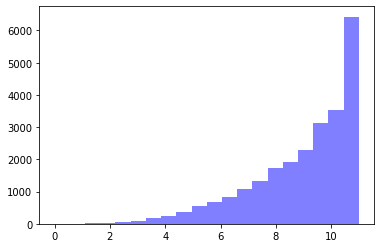

In [0]:
# Histogram plot of the idf values

num_bins = ceil((tfIdf_vectorizer.idf_.max()-tfIdf_vectorizer.idf_.min())/0.5)
hValues, bins, patches = plt.hist(tfIdf_vectorizer.idf_, num_bins, facecolor='blue',
                alpha=0.5, range=(0, int(tfIdf_vectorizer.idf_.max()+1)))
plt.show()

In [0]:
# Lets study the distribution of words in each of the bins
for bini in range(len(bins)-1):
  print("Bin : ",bini+1)
  print("Range : {} - {}".format(round(bins[bini],3), round(bins[bini+1],3)))
  print("No of words : {} which is {} % of total".format(hValues[bini], 
          round((hValues[bini]*100)/len(tfIdf_vectorizer.get_feature_names()),2)))
  print("Top 10 words : ")
  words = sorted([(word,score) for word,score in feature_Idf_Map.items()\
                 if score>=bins[bini] and score<=bins[bini+1]], 
                 key=lambda x:x[1], reverse=True)[:10]
  print(words)
  print("*"*100)

Bin :  1
Range : 0.0 - 0.55
No of words : 0.0 which is 0.0 % of total
Top 10 words : 
[]
****************************************************************************************************
Bin :  2
Range : 0.55 - 1.1
No of words : 2.0 which is 0.01 % of total
Top 10 words : 
[('nannan', 1.0460394199858651), ('students', 1.0080085502013645)]
****************************************************************************************************
Bin :  3
Range : 1.1 - 1.65
No of words : 10.0 which is 0.04 % of total
Top 10 words : 
[('many', 1.5766580863856858), ('help', 1.5164292506171393), ('they', 1.5022193040848788), ('the', 1.466500084265604), ('learn', 1.4627750651310945), ('not', 1.4507585683891664), ('classroom', 1.3946702211939477), ('learning', 1.3637010149387487), ('my', 1.244274308661387), ('school', 1.1629790147986256)]
****************************************************************************************************
Bin :  4
Range : 1.65 - 2.2
No of words : 28.0 which is 0.1

In [0]:
# we clearly see that the first 6 bins have very few words and the last bin has 
# words which are mostly digits in string format which do not add much meaning 

# llimit, hlimit = 3.3, 9.6
llimit, hlimit = 2, 10

def exclude_words(text):
  return ' '.join([word for word in text.split() if \
                    feature_Idf_Map.get(word) is None or 
                    (feature_Idf_Map.get(word) and \
                  (feature_Idf_Map.get(word)>=llimit and \
                      feature_Idf_Map.get(word)<=hlimit))])

In [0]:
# changing the essay text to exclude the extra words

dfX_train['mod_essay']=dfX_train.essay.apply(exclude_words)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
dfX_test['mod_essay']=dfX_test.essay.apply(exclude_words)

In [0]:
dfX_cv['mod_essay']=dfX_cv.essay.apply(exclude_words)

In [0]:
tokenizer_Essay2 = Tokenizer(oov_token='<oov>')
tokenizer_Essay2.fit_on_texts(dfX_train.mod_essay.to_list())

In [0]:
tokenised_essay2_train = tokenizer_Essay2.texts_to_sequences(dfX_train.mod_essay)
tokenised_essay2_cv = tokenizer_Essay2.texts_to_sequences(dfX_cv.mod_essay)
tokenised_essay2_test = tokenizer_Essay2.texts_to_sequences(dfX_test.mod_essay)
X_train_essay2 = pad_sequences(tokenised_essay2_train, maxlen=max_essay_length)
X_test_essay2 = pad_sequences(tokenised_essay2_test, maxlen=max_essay_length)
X_cv_essay2 = pad_sequences(tokenised_essay2_cv, maxlen=max_essay_length)

In [0]:
EMBEDDING_DIMS = 300     # glove vectors are 300 dims
VOCAB_SIZE = len(list(tokenizer_Essay2.word_counts.keys()))
embedding_matrix2 = np.zeros((VOCAB_SIZE+1, EMBEDDING_DIMS))
for word, i in tokenizer_Essay2.word_index.items():
    embedding_vector = glove.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix2[i-1] = embedding_vector

In [0]:
# Modified essay
mod_essay_Inp = Input(shape=(max_essay_length,),dtype='int32',
                  name='mod_essay_Inp')
embedded_mod_Essay = Embedding(input_dim=len(tokenizer_Essay2.word_index.items()),
                        output_dim=300,name='embedded_mod_Essay',
                        weights=[embedding_matrix2],
                        trainable=False)(mod_essay_Inp)
mod_essay_LSTM = LSTM(units=128, return_sequences=True)(embedded_mod_Essay)
mod_essay_Out = Flatten()(mod_essay_LSTM)

In [0]:
# concatenating all the outputs

concatenated_Outs2 = concatenate([school_state_out, teacher_Pref_out,
                pgCategory_Out,cleanCategory_Out,clean_subcategories_Out,
                mod_essay_Out,remaining_cols_Out])

In [0]:
outPut = Dense(128,activation='relu',
               kernel_initializer=initializers.he_normal(),
               kernel_regularizer=regularizers.l2(0.001))(concatenated_Outs2)
outPut = Dropout(0.4)(outPut)
outPut = Dense(64,activation='relu',
               kernel_initializer=initializers.he_normal(),
               kernel_regularizer=regularizers.l2(0.001))(outPut)
outPut = Dropout(0.4)(outPut)
outPut = BatchNormalization()(outPut)
outPut = Dense(32,activation='relu',
               kernel_initializer=initializers.he_normal(),
               kernel_regularizer=regularizers.l2(0.001))(outPut)
outPut = Dropout(0.4)(outPut)
outPut = Dense(2, activation = 'softmax')(outPut)

In [0]:
# create model with all the previously defined inputs
model2 = Model([school_state_inp,teacher_Pref_inp,pgCategory_Inp,
                cleanCategory_Inp,clean_subcategories_Inp,mod_essay_Inp,
                remaining_cols_Inp], outPut)
model2.compile(loss='categorical_crossentropy', 
               optimizer=optimizers.Adam(lr=0.0006,decay = 1e-4),
               metrics=[auc])
print(model2.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mod_essay_Inp (InputLayer)      [(None, 350)]        0                                            
__________________________________________________________________________________________________
school_state_inp (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
teacher_Pref_inp (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
pgCategory_Inp (InputLayer)     [(None, 1)]          0                                            
____________________________________________________________________________________________

In [0]:
# Lets run the model
filepath=dir_path+"best_weights2.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', 
                    verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

if os.path.isfile(dir_path+'best_weights2.hdf5'):
  model2.load_weights(dir_path+'best_weights2.hdf5')

model2.fit([X_train_schoolState,X_train_teacherPrefix,X_train_pgCategory,
           X_train_cleanCategory,X_train_cleanSubCategory,X_train_essay2,
           np.array(dfX_train['remaining_cols'].to_list())], to_categorical(y_train), 
           epochs=20,verbose=2,batch_size=256,validation_data=([X_cv_schoolState,
           X_cv_teacherPrefix,X_cv_pgCategory,X_cv_cleanCategory,
           X_cv_cleanSubCategory,X_cv_essay2,np.array(dfX_cv['remaining_cols'].to_list())]
           ,to_categorical(y_cv)),
           callbacks =callbacks_list)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 76473 samples, validate on 16387 samples
Epoch 1/20

Epoch 00001: val_auc improved from -inf to 0.59871, saving model to /content/drive/My Drive/Colab Notebooks/AppliedAI/LSTM_Donors_Choose/best_weights2.hdf5
76473/76473 - 146s - loss: 0.7770 - auc: 0.5182 - val_loss: 0.5696 - val_auc: 0.5987
Epoch 2/20

Epoch 00002: val_auc improved from 0.59871 to 0.60677, saving model to /content/drive/My Drive/Colab Notebooks/AppliedAI/LSTM_Donors_Choose/best_weights2.hdf5
76473/76473 - 143s - loss: 0.5873 - auc: 0.5376 - val_loss: 0.5348 - val_auc: 0.6068
Epoch 3/20

Epoch 00003: val_auc improved from 0.60677 to 0.60850, saving model to /content/drive/My Drive/Colab Notebooks/AppliedAI/LSTM_Donors_Choose/best_weights2.hdf5
76473/76473 - 143s - loss: 0.5357 - auc: 0.5562 - val_loss: 0.5063 - val_auc: 0.6085
Epoch 4/20

Epoch 00004: val_auc did not improve from 0.60850
76473/76473 - 141s - loss: 0.

In [0]:
# AUC for test data
print("Test AUC for Model2 : %0.3f"%roc_auc_score(to_categorical(y_test),
      model2.predict([X_test_schoolState,X_test_teacherPrefix,X_test_pgCategory,
      X_test_cleanCategory,X_test_cleanSubCategory,
      X_test_essay2,np.array(dfX_test['remaining_cols'].to_list())]),
      average='weighted'))

      # Last 0.683

Test AUC for Model2 : 0.718


In [0]:
# AUC for test data
print("Test AUC for Model2 : %0.3f"%roc_auc_score(to_categorical(y_test),
      model2.predict([X_test_schoolState,X_test_teacherPrefix,X_test_pgCategory,
      X_test_cleanCategory,X_test_cleanSubCategory,
      X_test_essay2,np.array(dfX_test['remaining_cols'].to_list())]), 
      average='micro'))

# 0.876

Test AUC for Model2 : 0.905


In [0]:
table.add_row(['Model 2',0.718,0.905])

### Model-3

<img src='https://i.imgur.com/fkQ8nGo.png'>
ref: https://i.imgur.com/fkQ8nGo.png


- __input_seq_total_text_data__: <br>
<pre>
    . Use text column('essay'), and use the Embedding layer to get word vectors. <br>
    . Use given predefined glove word vectors, don't train any word vectors. <br>
    . Use LSTM that is given above, get the LSTM output and Flatten that output. <br>
    . You are free to preprocess the input text as you needed. <br>
</pre>
- __Other_than_text_data__:<br>
<pre>
    . Convert all your Categorical values to onehot coded and then concatenate all these onehot vectors <br>
    . Neumerical values and use <a href='https://keras.io/getting-started/sequential-model-guide/#sequence-classification-with-1d-convolutions'>CNN1D</a> as shown in above figure. <br>
    . You are free to choose all CNN parameters like kernel sizes, stride.<br>
    
</pre>

In [45]:
# We will use the 'Essay' layer from the Model1
# Lets work on the all other columns

mlbinarizer_schoolState = MultiLabelBinarizer()
mlbinarizer_schoolState.fit([dfX_train.school_state.to_list()])

MultiLabelBinarizer(classes=None, sparse_output=False)

In [0]:
X_train_schoolState = mlbinarizer_schoolState.transform(\
                        dfX_train.school_state.apply(lambda x : [x]))
X_test_schoolState = mlbinarizer_schoolState.transform(\
                        dfX_test.school_state.apply(lambda x : [x]))
X_cv_schoolState = mlbinarizer_schoolState.transform(\
                        dfX_cv.school_state.apply(lambda x : [x]))

In [47]:
print(X_train_schoolState.shape)

(76473, 51)


In [0]:
mlbinarizer_teacherPrefix = MultiLabelBinarizer()
mlbinarizer_teacherPrefix.fit([dfX_train.teacher_prefix.to_list()])

X_train_teacherPrefix = mlbinarizer_teacherPrefix.transform(\
                      dfX_train.teacher_prefix.apply(lambda x : [x]))
X_test_teacherPrefix = mlbinarizer_teacherPrefix.transform(\
                      dfX_test.teacher_prefix.apply(lambda x : [x]))
X_cv_teacherPrefix = mlbinarizer_teacherPrefix.transform(\
                      dfX_cv.teacher_prefix.apply(lambda x : [x]))

In [49]:
print(X_train_teacherPrefix.shape)

(76473, 5)


In [0]:
mlbinarizer_pgCategory = MultiLabelBinarizer()
mlbinarizer_pgCategory.fit([dfX_train.project_grade_category.to_list()])

X_train_pgCategory = mlbinarizer_pgCategory.transform(\
                      dfX_train.project_grade_category.apply(lambda x : [x]))
X_test_pgCategory = mlbinarizer_pgCategory.transform(\
                      dfX_test.project_grade_category.apply(lambda x : [x]))
X_cv_pgCategory = mlbinarizer_pgCategory.transform(\
                      dfX_cv.project_grade_category.apply(lambda x : [x]))

In [51]:
print(X_train_pgCategory.shape)

(76473, 4)


In [0]:
mlbinarizer_cleanCategory = MultiLabelBinarizer()
mlbinarizer_cleanCategory.fit([dfX_train.clean_categories.to_list()])

X_train_cleanCategory = mlbinarizer_cleanCategory.transform(\
                      dfX_train.clean_categories.apply(lambda x : [x]))
X_test_cleanCategory = mlbinarizer_cleanCategory.transform(\
                      dfX_test.clean_categories.apply(lambda x : [x]))
X_cv_cleanCategory = mlbinarizer_cleanCategory.transform(\
                      dfX_cv.clean_categories.apply(lambda x : [x]))

In [53]:
print(X_train_cleanCategory.shape)

(76473, 51)


In [54]:
mlbinarizer_cleanSubCategory = MultiLabelBinarizer()
mlbinarizer_cleanSubCategory.fit([dfX_train.clean_subcategories.to_list()])

X_train_cleanSubCategory = mlbinarizer_cleanSubCategory.transform(\
                      dfX_train.clean_subcategories.apply(lambda x : [x]))
X_test_cleanSubCategory = mlbinarizer_cleanSubCategory.transform(\
                      dfX_test.clean_subcategories.apply(lambda x : [x]))
X_cv_cleanSubCategory = mlbinarizer_cleanSubCategory.transform(\
                      dfX_cv.clean_subcategories.apply(lambda x : [x]))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['civics_government parentinvolvement', 'civics_government teamsports', 'earlydevelopment history_geography', 'economics foreignlanguages', 'financialliteracy health_lifescience', 'socialsciences teamsports'] will be ignored
  .format(sorted(unknown, key=str)))
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:951: UserWarning: unknown class(es) ['civics_government teamsports', 'economics music', 'economics other', 'financialliteracy health_lifescience', 'financialliteracy health_wellness', 'socialsciences teamsports'] will be ignored
  .format(sorted(unknown, key=str)))


In [55]:
print(X_train_cleanSubCategory.shape)

(76473, 392)


In [0]:
X_train_concat = np.hstack((X_train_schoolState,X_train_teacherPrefix,X_train_pgCategory,
          X_train_cleanCategory,X_train_cleanSubCategory))
X_test_concat = np.hstack((X_test_schoolState,X_test_teacherPrefix,X_test_pgCategory,
          X_test_cleanCategory,X_test_cleanSubCategory))
X_cv_concat = np.hstack((X_cv_schoolState,X_cv_teacherPrefix,X_cv_pgCategory,
          X_cv_cleanCategory,X_cv_cleanSubCategory))

In [0]:
X_train_concat=np.expand_dims(X_train_concat, axis=2)
X_test_concat=np.expand_dims(X_test_concat, axis=2)
X_cv_concat=np.expand_dims(X_cv_concat, axis=2)

In [58]:
X_train_concat.shape

(76473, 503, 1)

In [0]:
dims = X_train_concat.shape[1]

In [0]:
stacked_Inp = Input(shape=(dims,1), name='stacked_Inp')
conv_out = Conv1D(128, kernel_size=(3),activation='relu')(stacked_Inp)  #128
conv_out = Conv1D(64, kernel_size=(2),activation='relu')(conv_out)  # 64
# conv_out = Conv1D(32, kernel_size=(2),activation='relu')(conv_out)    Ommiting
#                 this layer
conv_out = Flatten()(conv_out)

In [0]:
concatenated_Outs3=concatenate([essay_Out, conv_out])

In [0]:
# We are using the same configuration as the model1

outPut = Dense(256,activation='relu',
               kernel_initializer=initializers.he_normal(),
               kernel_regularizer=regularizers.l2(0.001))(concatenated_Outs3)
outPut = Dropout(0.5)(outPut)
outPut = Dense(64,activation='relu',
               kernel_initializer=initializers.he_normal(),
               kernel_regularizer=regularizers.l2(0.001))(outPut)
outPut = Dropout(0.5)(outPut)
outPut = BatchNormalization()(outPut)
outPut = Dense(32,activation='relu',
               kernel_initializer=initializers.he_normal(),
               kernel_regularizer=regularizers.l2(0.001))(outPut)
outPut = Dropout(0.5)(outPut)
outPut = Dense(2, activation = 'softmax')(outPut)

In [71]:
# create model with all the previously defined inputs
model3 = Model([essay_Inp, stacked_Inp], outPut)
model3.compile(loss='categorical_crossentropy', 
               optimizer=optimizers.Adam(lr=0.0006,decay = 1e-4),
               metrics=[auc])
print(model3.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
essay_Inp (InputLayer)          [(None, 350)]        0                                            
__________________________________________________________________________________________________
stacked_Inp (InputLayer)        [(None, 503, 1)]     0                                            
__________________________________________________________________________________________________
embedded_Essay (Embedding)      (None, 350, 300)     14799000    essay_Inp[0][0]                  
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 501, 128)     512         stacked_Inp[0][0]                
____________________________________________________________________________________________

In [72]:
X_cv_essay.shape

(16387, 350)

In [74]:
# Lets run the model
filepath=dir_path+"best_weights3.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_auc', 
                    verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

if os.path.isfile(dir_path+'best_weights3.hdf5'):
  model3.load_weights(dir_path+'best_weights3.hdf5')

model3.fit([X_train_essay, X_train_concat], to_categorical(y_train), 
           epochs=5,verbose=2,batch_size=256,
           validation_data=([X_cv_essay,X_cv_concat],to_categorical(y_cv)),
           callbacks =callbacks_list)

Train on 76473 samples, validate on 16387 samples
Epoch 1/5

Epoch 00001: val_auc improved from -inf to 0.71909, saving model to /content/drive/My Drive/Colab Notebooks/AppliedAI/LSTM_Donors_Choose/best_weights3.hdf5
76473/76473 - 146s - loss: 0.4252 - auc: 0.7538 - val_loss: 0.4245 - val_auc: 0.7191
Epoch 2/5

Epoch 00002: val_auc did not improve from 0.71909
76473/76473 - 141s - loss: 0.4152 - auc: 0.7684 - val_loss: 0.4411 - val_auc: 0.7156
Epoch 3/5

Epoch 00003: val_auc did not improve from 0.71909
76473/76473 - 140s - loss: 0.4072 - auc: 0.7891 - val_loss: 0.4382 - val_auc: 0.7171
Epoch 4/5

Epoch 00004: val_auc did not improve from 0.71909
76473/76473 - 139s - loss: 0.3995 - auc: 0.8046 - val_loss: 0.4441 - val_auc: 0.7080
Epoch 5/5

Epoch 00005: val_auc did not improve from 0.71909
76473/76473 - 139s - loss: 0.3859 - auc: 0.8274 - val_loss: 0.4676 - val_auc: 0.7025


In [75]:
# AUC for test data
print("Test AUC for Model3 : %0.3f"%roc_auc_score(to_categorical(y_test),
      model3.predict([X_test_essay, X_test_concat]),
      average='weighted'))

Test AUC for Model3 : 0.707


In [76]:
# AUC for test data
print("Test AUC for Model3 : %0.3f"%roc_auc_score(to_categorical(y_test),
      model3.predict([X_test_essay, X_test_concat]), 
      average='micro'))

Test AUC for Model3 : 0.902


In [0]:
table.add_row(['Model 3',0.707,0.902])

In [8]:
print(table)

+---------+-------------------+----------------+
|  Model  | Weighted Test AUC | Micro Test AUC |
+---------+-------------------+----------------+
| Model 1 |       0.762       |     0.916      |
| Model 2 |       0.718       |     0.905      |
| Model 3 |       0.707       |     0.902      |
+---------+-------------------+----------------+
